<a href="https://colab.research.google.com/github/ArthurBoschet/Chilblains-Analysis/blob/main/logistic_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00


# Setup

In [32]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount = False)

FOLDER = "drive/MyDrive/Derm_Registry_Derm_Data_Project/"
dataset_path = os.path.join(FOLDER, 'dataset.xlsx')
save_path = os.path.join(FOLDER, 'figures')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#target column name
TARGET_NAME = 'What is the morphology of the skin findings? Mark all that apply.\xa0 \xa0 \xa0 Please see below for example images of rash morphology.\xa0 ### Pernio (Chilblains)'

#level of significance to keep logistic regression coefficient
SIGNIFICANCE = 0.01


# Imports

In [34]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tqdm import tqdm
import plotly.graph_objects as go

#scikit learn
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

#skopt
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

#statsmodel api
import statsmodels.api as sm

# Functions

In [35]:
def multi_label_binarize(column):
  '''
  Takes in a column with features such as 'a,c,f...' and returns a dataframe with columns a,b,c,d,...,f
  Parameters:
    column (pandas.core.series.Series): column of dataframe entered
  Returns:
    data (pandas.DataFrame)
  '''
  column_name = column.name
  column = [el.split(',') for el in column.values.astype(str)]

  #multilabel binarize
  mlb = MultiLabelBinarizer()
  data = mlb.fit_transform(column)
  data = pd.DataFrame(data, columns=[column_name+' ### '+pos for pos in mlb.classes_])
  return data

def get_nan_columns(dataframe):
  '''
  Get the NaN columns
  Parameters:
    dataframe (pandas.core.frame.DataFrame): datafram from which columns are removed.
  Returns:
    nan_columns (List[str]): list of nan columns.
  '''
  nan_columns = [column for column in dataframe.columns if re.search("^.* nan", column)]
  return nan_columns

def filter_nan_columns(dataframe):
  '''
  Remove columns with nan at the end of its name (aka columns representing nans)
  Parameters:
    dataframe (pandas.core.frame.DataFrame): datafram from which columns are removed
  Returns:
    dataframe (pandas.core.frame.DataFrame): cleaned dataframe
  '''
  nan_columns = get_nan_columns(dataframe)
  dataframe = dataframe.drop(nan_columns, axis=1)
  return dataframe

# Analysis

## Preprocessing (Data cleaning)

In [36]:
#load the dataset into pandas
df = pd.read_excel(dataset_path)

#proportion of actual values per column (not nan)
columns_filled_proportion = 1-df.isna().mean()

#sort by how "filled" column is
columns_filled_proportion = columns_filled_proportion.sort_values(ascending=False)

#sort the columns of the dataframe by prevalence of values
df = df[columns_filled_proportion.keys()]

### Seperate column types

In [37]:
#get the data types in each column
types_in_df = {str(t): df.dtypes.values == t for t in np.unique(df.dtypes.values)}

#print the types
print("column types available in data")
for t in types_in_df.keys():
  print(f"The type is: {t}")

#categorical columns but not location/time (different ecodings)
categorical_columns = [df[col].name for col in df.columns[types_in_df['object']]]# if col not in location_columns]

#numerical columns
columns_numerical = df.columns[np.logical_or(types_in_df['int64'], types_in_df['float64'])]

print("################################### CATEGORICAL ###################################")
print(f"The number of categorical columns is {len(categorical_columns)}")
for col in categorical_columns:
  print(f"    ==> {col}")

print("\n\n################################### NUMERICAL ###################################")
#numerical data
numeric_data = df[columns_numerical]

#drop the record ID because it is not an interesting number
numeric_data = numeric_data.drop("Record ID", axis=1)#.fillna(numeric_data.mean())

print(f"\nThe number of float/int columns is {len(columns_numerical)}")
for col in numeric_data.columns:
  print(f"    ==> {col}")

column types available in data
The type is: int64
The type is: float64
The type is: object
################################### CATEGORICAL ###################################
The number of categorical columns is 76
    ==> What was the patient's assigned sex at birth?
    ==> Did the patient have new skin, nail, hair, mucous membrane or other dermatologic changes in the setting of possible or confirmed Covid-19?
    ==> Hospital or clinic country 
    ==> What is the morphology of the skin findings? Mark all that apply.      Please see below for example images of rash morphology. 
    ==> Does this patient have a pre-existing dermatologic condition?
    ==> Which dermatologic condition(s) were associated with the Covid-19 infection? Mark all that apply.
    ==> Patient's country of residence
    ==> What areas of the body do the skin findings involve?  Mark all that apply. 
    ==> Were there any COVID-19 complications?
    ==> Was the patient hospitalized during COVID-19 illness?
    

### Categorical Data

#### Encodings

In [38]:
#process categorical columns (if categories are {a,b,c,d,e,f,g} then convert "a,b,d,f" to [1,1,0,1,0,1,0])
data_transformed = pd.concat([multi_label_binarize(df[name]) for name in categorical_columns], axis=1)

#remove columns with only one value
selector = VarianceThreshold(threshold=0)
data_array_kept = selector.fit_transform(data_transformed)
data_transformed = pd.DataFrame(data_array_kept, columns=selector.get_feature_names_out(data_transformed.columns))

#### Self-reporting bias in other chilblains questions (we remove other questions)

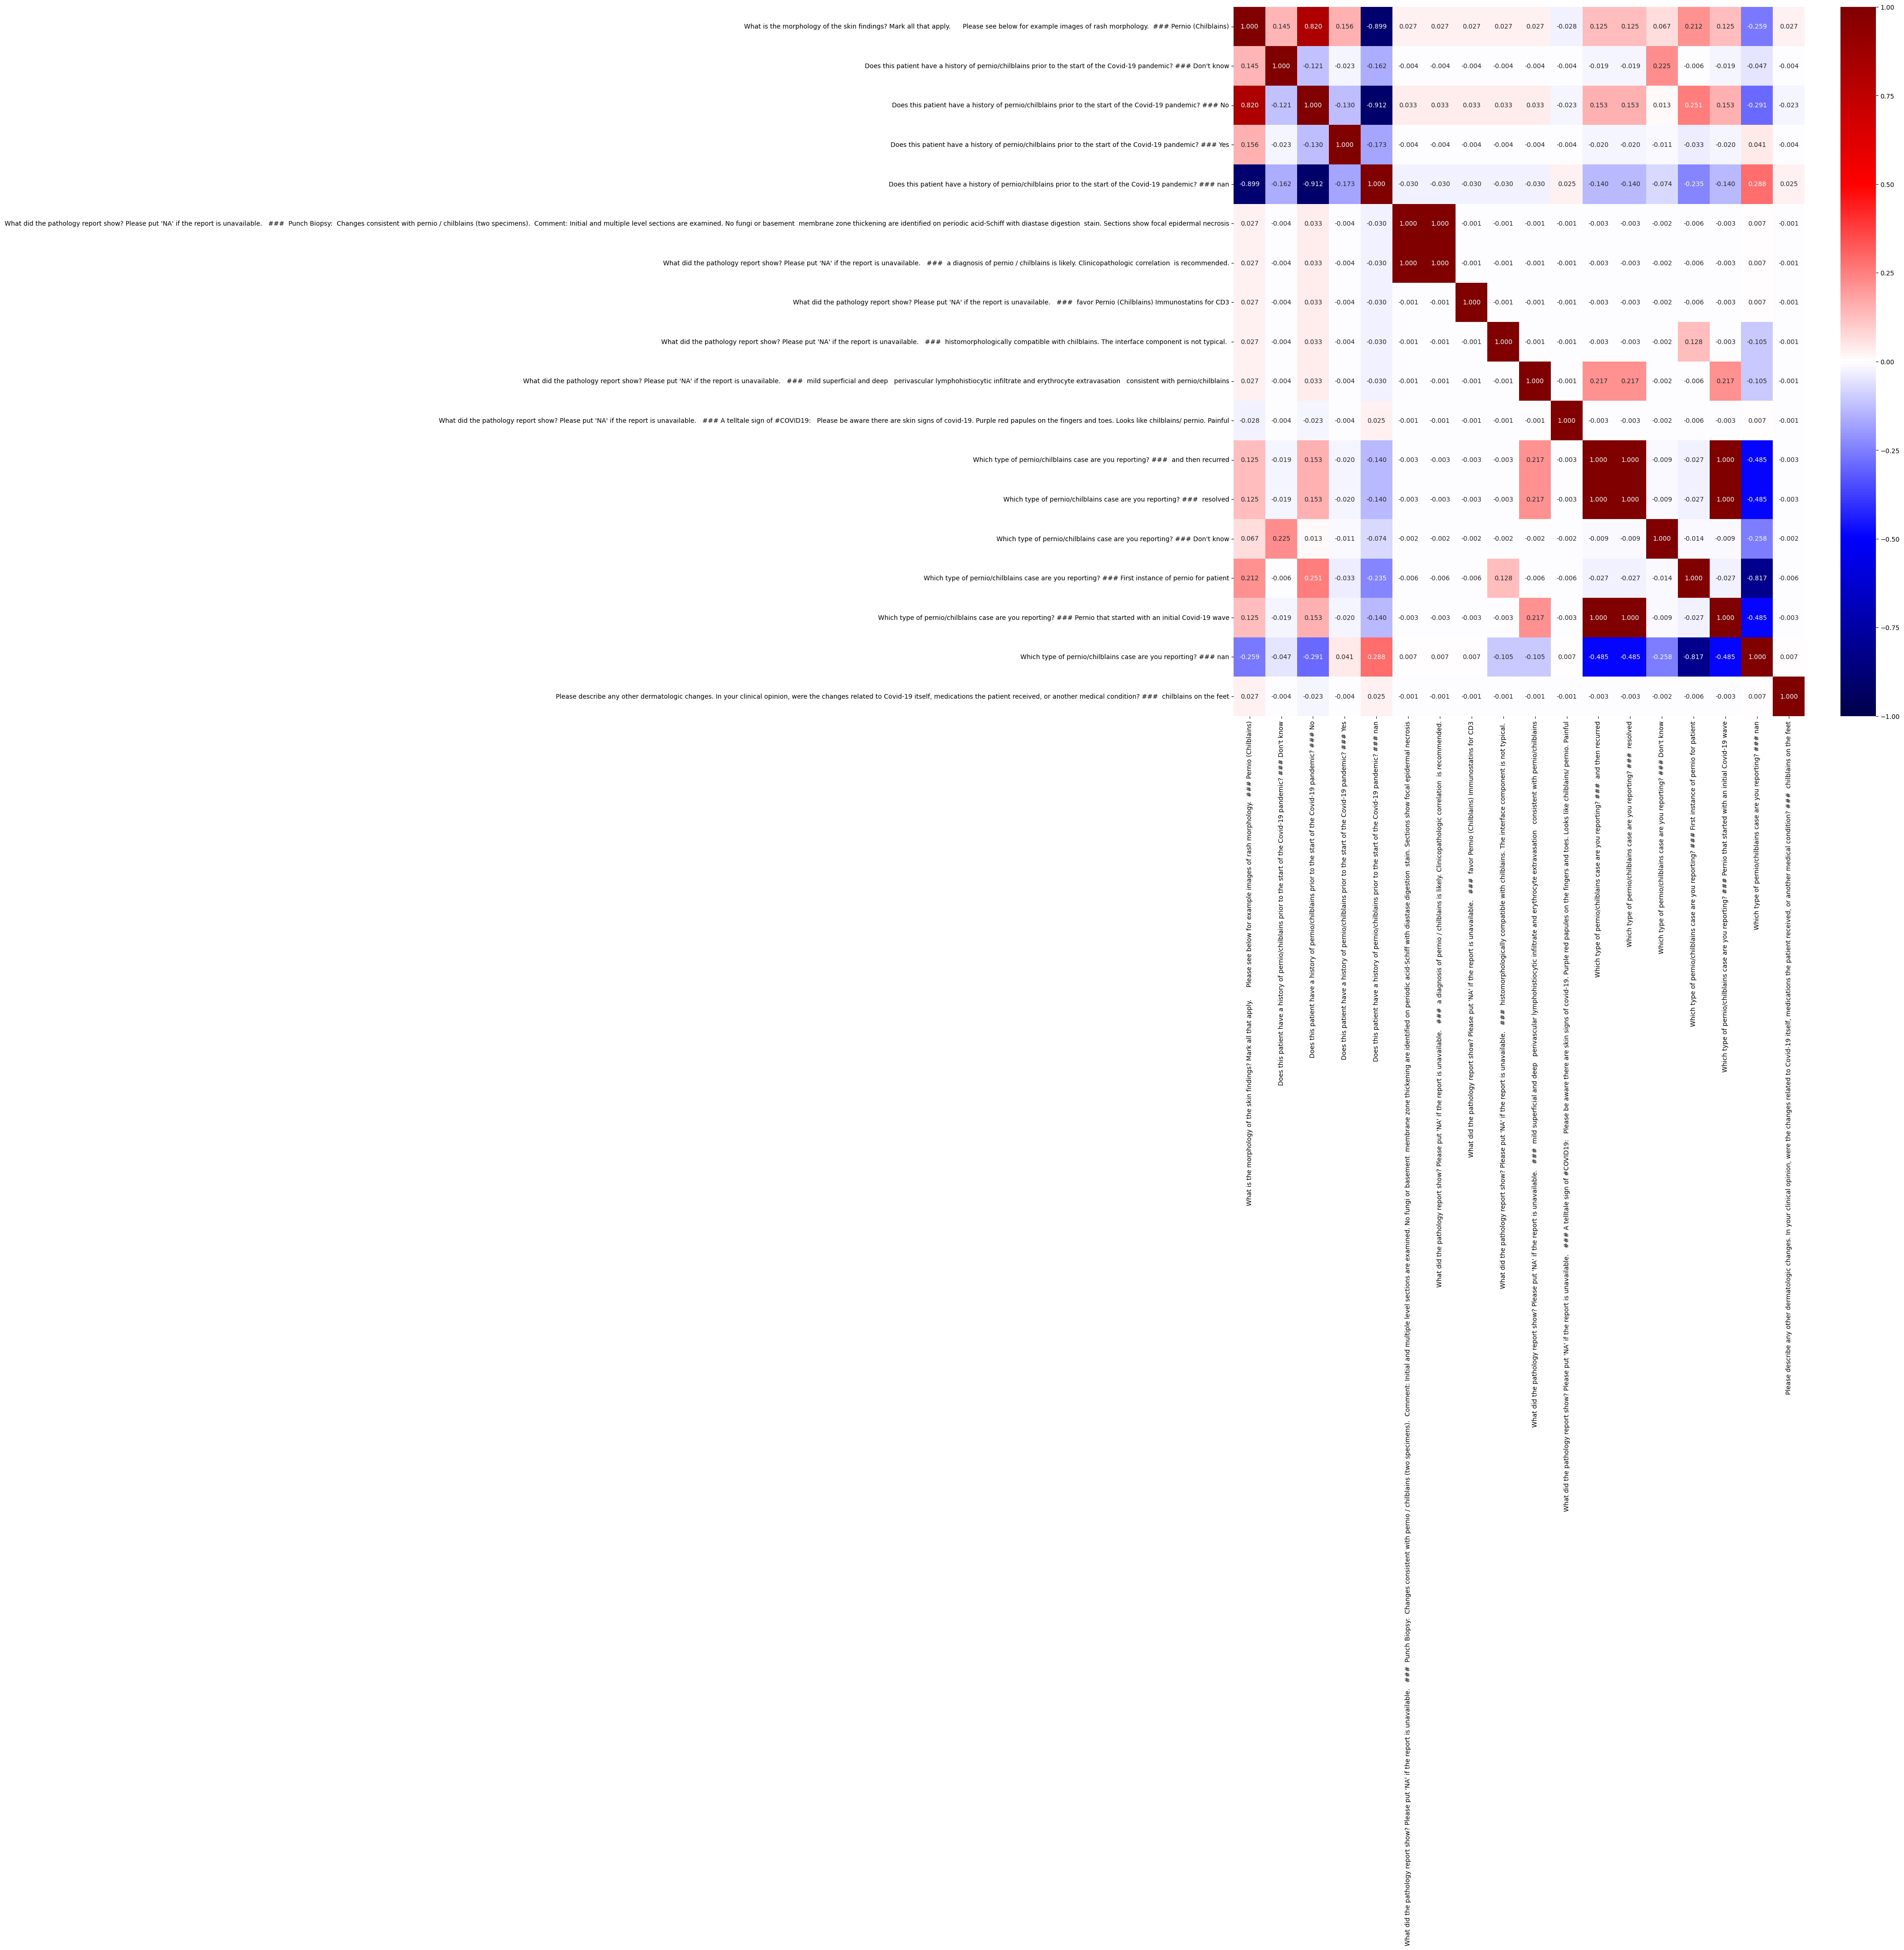

In [39]:
#show the self reporting bias
chilblains_cols = [c for c in data_transformed.columns if re.search(".*chilblains.*", c.lower())]
plt.figure(figsize=(20,20))
sns.heatmap(data_transformed[chilblains_cols].corr(), annot=True, fmt=".3f", cmap='seismic', vmin=-1, vmax=1)
plt.show()

In [40]:
#column name of history of chilblains being nan
hist_nan_name = 'Does this patient have a history of pernio/chilblains prior to the start of the Covid-19 pandemic? ### nan'

#get chilblains history not filled by patient
hist_nan = data_transformed[hist_nan_name].values

#history filled by patient and having chilblains
hist = 1-hist_nan
chil = data_transformed[TARGET_NAME].values

#compute conditional probabilities
p_chil_given_hist = np.mean(np.logical_and(chil, hist))/np.mean(hist)
p_chil_given_not_hist = np.mean(np.logical_and(chil, hist_nan))/np.mean(hist_nan)

print(f"hist = 'history about chilblains filled in by patient' \nchil = 'patient has chilblains' \n\nP(chil | hist) = P(chil and hist)/P(hist) = {p_chil_given_hist}")
print(f"P(chil | not hist) = P(chil and not hist)/P(not hist) = {p_chil_given_not_hist}\n\n")

data_transformed.drop(chilblains_cols[1:],inplace=True,axis=1)

print("Therefore we remove the following columns from the categorical data:")
for col in chilblains_cols[1:]:
  print(f"    ==>{col}")

hist = 'history about chilblains filled in by patient' 
chil = 'patient has chilblains' 

P(chil | hist) = P(chil and hist)/P(hist) = 1.0
P(chil | not hist) = P(chil and not hist)/P(not hist) = 0.0969945355191257


Therefore we remove the following columns from the categorical data:
    ==>Does this patient have a history of pernio/chilblains prior to the start of the Covid-19 pandemic? ### Don't know
    ==>Does this patient have a history of pernio/chilblains prior to the start of the Covid-19 pandemic? ### No
    ==>Does this patient have a history of pernio/chilblains prior to the start of the Covid-19 pandemic? ### Yes
    ==>Does this patient have a history of pernio/chilblains prior to the start of the Covid-19 pandemic? ### nan
    ==>What did the pathology report show? Please put 'NA' if the report is unavailable.   ###  Punch Biopsy:  Changes consistent with pernio / chilblains (two specimens).  Comment: Initial and multiple level sections are examined. No fungi or basement  

#### Remove NaN columns

In [41]:
#filter out the nan columns (not interesting)
data_transformed = filter_nan_columns(data_transformed)

#get the feature names
feature_names = [column for column in data_transformed.columns if column != TARGET_NAME]

#get the categorical data and target column
categorical_data = data_transformed[feature_names]
Y = data_transformed[TARGET_NAME]

####Remove Columns that are all the same

In [42]:
print(f"Shape of the categorical features before removing using values is: {categorical_data.shape}")

p = 1/1333
variance_selector = VarianceThreshold(threshold=(p * (1 - p))).fit(categorical_data)
categorical_data = pd.DataFrame(variance_selector.transform(categorical_data), columns=variance_selector.get_feature_names_out())

print(f"Shape of the categorical features after removing using values is: {categorical_data.shape}")

Shape of the categorical features before removing using values is: (1333, 1118)
Shape of the categorical features after removing using values is: (1333, 952)


### Numerical Data

####Remove Columns that are all the same

In [43]:
print(f"Shape of the numerical features before removing using values is: {numeric_data.shape}")

variance_selector = VarianceThreshold(threshold=0).fit(numeric_data)
numeric_data = pd.DataFrame(variance_selector.transform(numeric_data), columns=variance_selector.get_feature_names_out())

print(f"Shape of the numerical features after removing using values is: {numeric_data.shape}")

Shape of the numerical features before removing using values is: (1333, 11)
Shape of the numerical features after removing using values is: (1333, 8)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_variance_threshold.py:119: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


## Model Building

### Dataset (after preprocessing)

In [47]:
X = pd.concat([categorical_data, numeric_data], axis=1)

processed_dataset = pd.concat([X, Y], axis=1)

processed_dataset.to_excel(FOLDER + "/processed_dataset.xlsx")

### Define the machine learning pipeline

In [45]:
def make_pipeline(
    numeric_features,
    categorical_features,
    k_numerical=10,
    k_categorical=50,
    imputer="mean",
    ):
  '''
  Machine learning pipeline used for this project.

  Parameters
  ----------
    numeric_features : List[str]
      List of the column names of the numerical features in the input pandas dataframe.
    categorical_features : List[str]
      List of the column names of the categorical features in the input pandas dataframe.
    k_numerical : int
      Number of numerical features to keep.
    k_categorical : int
      Number of categorical features to keep.
    imputer : str
      Type of imputer used.
    variance_threshold: float
      Variance threshold used.
  '''

  #transformer for the numeric
  numeric_transformer = Pipeline(steps=[
      ("imputer", SimpleImputer(strategy=imputer)),
      ("select_best", SelectKBest(f_classif, k=k_numerical) if k_numerical is not None else "passthrough"),
      ("scaler", StandardScaler())
  ])

  #categorical features
  categorical_transformer = Pipeline(steps=[
      ("select_best", SelectKBest(chi2, k=k_categorical) if k_categorical is not None else "passthrough"),
  ])

  #column transformer
  preprocessor = ColumnTransformer(transformers=[
      ("num_transform", numeric_transformer, numeric_features),
      ("cat_transform", categorical_transformer, categorical_features)
  ])

  #pipeline
  pipeline = Pipeline(
              steps=[
                  ("preprocesser", preprocessor),
                  ("classifier", LogisticRegression(solver='lbfgs', penalty=None, max_iter=10000))
                    ]
            )

  return pipeline

###Nested k-fold (hyperparameter search + unbiased accuracy esimation)

################################## Pipeline Setup #################################
Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('num_transform',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('select_best',
                                                                   SelectKBest()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['What is the patient's age in years?',
       'How many days after Covid symptoms started did the rash develop?',
       'Approximately how many days passed from COVID-19 symptom onset to resolution?'...
       'Other negative antibody ### nucleocapsid',
       'Oth

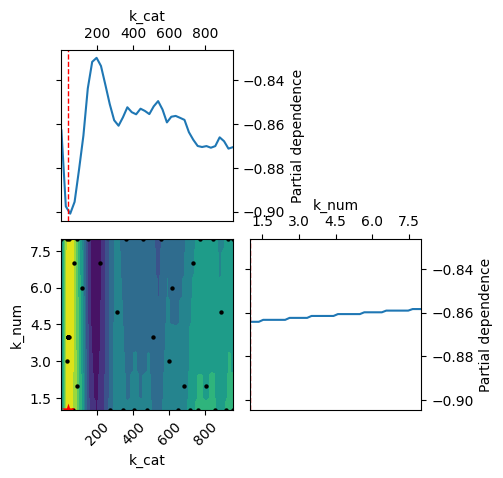

+++++++++++++++++++++ fold 2 +++++++++++++++++++++


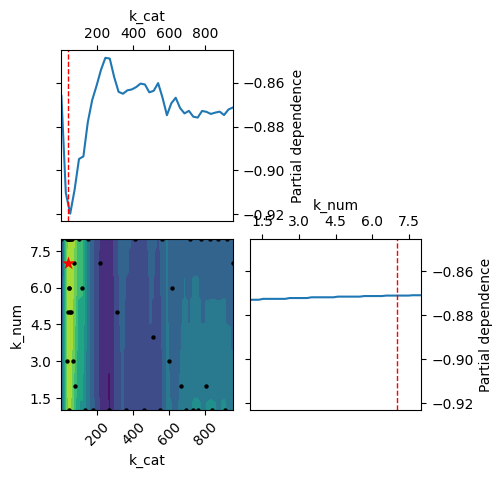

+++++++++++++++++++++ fold 3 +++++++++++++++++++++


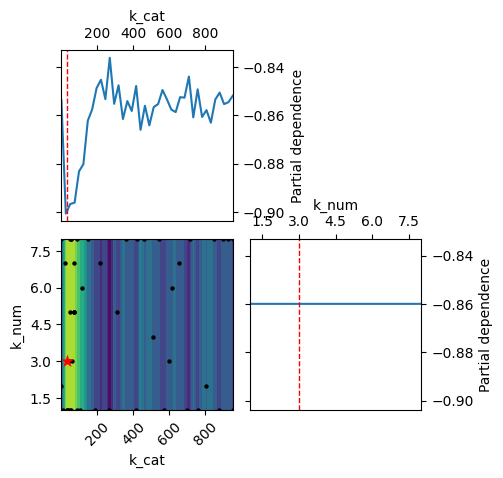

+++++++++++++++++++++ fold 4 +++++++++++++++++++++


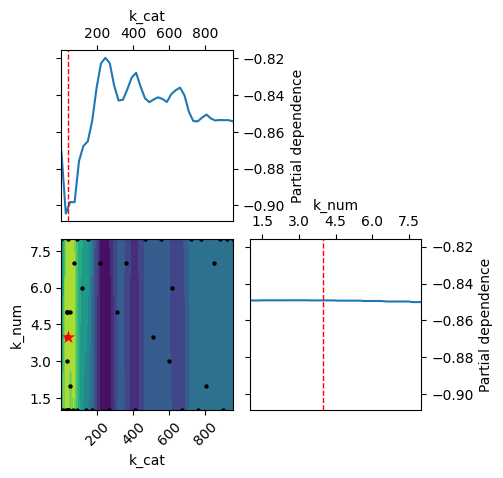

+++++++++++++++++++++ fold 5 +++++++++++++++++++++


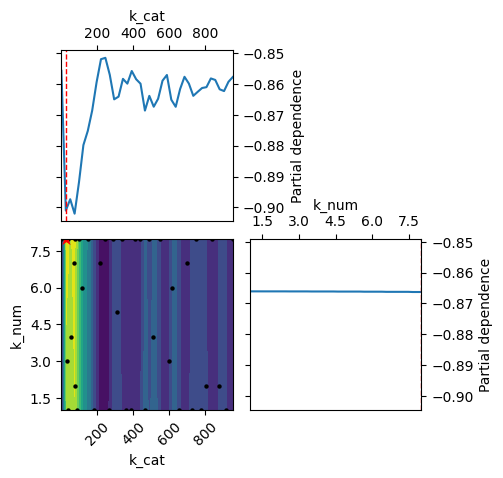

----------------------- Hyperparameter Search (outer loop) -----------------------
The average best hyperparameters are: k_numerical=4 and k_categorical=33
The test accuracy (outer loop) is 0.9077356312128637 ± 0.01215418859056596


In [46]:
#seed experiment
SEED=32

print("################################## Pipeline Setup #################################")

#get the numerical features
numeric_features = numeric_data.columns

#categorical features
categorical_features = categorical_data.columns

#instanciate pipeline
pipeline = make_pipeline(numeric_features, categorical_features)

print(pipeline)

#hyperparameter search (imputer type) and number of categorical features to keep (k)
param_grid = {
        "preprocesser__num_transform__select_best__k": Integer(1, numeric_features.shape[0]),
        "preprocesser__cat_transform__select_best__k": Integer(1, categorical_features.shape[0]),
    }

inner_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


print(" Nested K-fold Cross Validation ".center(80, "-"))
ks_categorical = []
ks_numerical = []
accuracies = []

with warnings.catch_warnings(record=True):
  for i, (train_index, test_index) in enumerate(outer_cv.split(X)):

      print(f" fold {i+1} ".center(50, "+"))

      #setup bayesian search for inner loop
      opt = BayesSearchCV(
        pipeline,
        param_grid,
        n_iter=50,
        cv=inner_cv,
        random_state=SEED,
      )

      #get the optimizing fold
      X_train, y_train = X.iloc[train_index], Y.iloc[train_index]

      #optimize the hyperparameter space
      opt.fit(X_train, y_train)

      #save the best hyperparameters
      ks_categorical.append(opt.best_params_['preprocesser__cat_transform__select_best__k'])
      ks_numerical.append(opt.best_params_['preprocesser__num_transform__select_best__k'])

      #plot the hyperparameter search
      ax = plot_objective(opt.optimizer_results_[0],
                        dimensions=["k_cat", "k_num"],
                        n_minimum_search=int(1e8),
                        )
      plt.show()

      #evaluate generalization performance (accuracy)
      model = make_pipeline(
                numeric_features,
                categorical_features,
                k_numerical=ks_numerical[-1],
                k_categorical=ks_categorical[-1],
                imputer="mean",
            )

      X_test, y_test = X.iloc[test_index], Y.iloc[test_index]
      model.fit(X_train, y_train)
      accuracies.append(model.score(X_test, y_test))




print("----------------------- Hyperparameter Search (outer loop) -----------------------")
#get the best hyperparameters
k_categorical = int(np.mean(ks_categorical))
k_numerical = int(np.mean(ks_numerical))

print(f"The average best hyperparameters are: k_numerical={k_numerical} and k_categorical={k_categorical}")
print(f"The test accuracy (outer loop) is {np.mean(accuracies)} ± {np.std(accuracies)}")

## Statistical Analysis

-> statsmodels: Econometric and statistical modeling with python

-> https://www.statsmodels.org/stable/index.html



In [ ]:
print("###################### PROCESSING THE ENTIRE DATASET ######################\n")

print(f"----------------------- numerical features (k_numerical={k_numerical}) -----------------------")
#process the numerical features
imputed_numerical = pd.DataFrame(
    SimpleImputer(strategy="mean").fit_transform(X.loc[:,numeric_features]),
    columns=X.loc[:,numeric_features].columns
    )

numeric_transformer = Pipeline(steps=[
      ("select_best", SelectKBest(f_classif, k=k_numerical)),
      ("scaler", StandardScaler())
  ])

X_num = pd.DataFrame(
    numeric_transformer.fit_transform(imputed_numerical, Y),
    columns=numeric_transformer["select_best"].get_feature_names_out(),
)

print(f"----------------------- categorical features (k={k_categorical}) -----------------------\n")
#get the categorical features
select = SelectKBest(chi2, k=k_categorical)
X_cat = pd.DataFrame(
    select.fit_transform(X.loc[:, categorical_features],Y),
    columns=select.get_feature_names_out(),
    )

X_processed_selected = pd.concat([X_num, X_cat], axis=1)

print(f"The number of kept columns in the dataset is {len(X_processed_selected.columns)}.\nThe columns kept are: ")
for col in X_processed_selected.columns:
  print(f"      ==> {col}")

#fit the statsmodel logistic regression
print(f"----------------------- Statsmodel Logistic Regression -----------------------\n")

#logistic model
X_processed_selected = sm.add_constant(X_processed_selected)
logit = sm.Logit(Y, X_processed_selected)
results = logit.fit()

#display the results
print(results.summary())

#get the pandas coef results
LRresult = (results.summary2().tables[1])
filename_all = FOLDER + "/logistic_regression_coefficients_all.xlsx"
LRresult.to_excel(filename_all)

filename_significant = FOLDER + f"/logistic_regression_coefficients_significant_{SIGNIFICANCE}.xlsx"
significant_coefs = LRresult[LRresult["P>|z|"] < SIGNIFICANCE]
significant_coefs.to_excel(filename_significant)

#get the odds ratios
odds_ratios = pd.concat([np.exp(LRresult.iloc[1:, [0,-2,-1]]), LRresult.iloc[1:, [2,3]]], axis=1).iloc[:,[0,-2,-1,1,2]]
odds_ratios.columns = ["OR"] + list(odds_ratios.columns[1:])

numerical_stats = pd.concat([imputed_numerical.mean(), imputed_numerical.std()], axis=1)
numerical_stats.columns = ["Mean", "SD"]
numerical_stats = numerical_stats.loc[numeric_transformer["select_best"].get_feature_names_out()]

proportions = pd.DataFrame(X.loc[:, select.get_feature_names_out()].mean())
proportions.columns = ["Proportion"]

odds_ratios = pd.concat([odds_ratios, numerical_stats, proportions], axis=1)


filename_all = FOLDER + "/logistic_regression_odds_ratios_all.xlsx"
odds_ratios.to_excel(filename_all)

filename_significant = FOLDER + f"/logistic_regression_odds_ratios_significant_{SIGNIFICANCE}.xlsx"
significant_odds_ratios = odds_ratios[odds_ratios["P>|z|"] < SIGNIFICANCE]
significant_odds_ratios.to_excel(filename_significant)


###################### PROCESSING THE ENTIRE DATASET ######################

----------------------- numerical features (k_numerical=4) -----------------------
----------------------- categorical features (k=39) -----------------------

The number of kept columns in the dataset is 43.
The columns kept are: 
      ==> What is the patient's age in years?
      ==> How many days after Covid symptoms started did the rash develop?
      ==> Approximately how many days passed from COVID-19 symptom onset to resolution?
      ==> For how many days did the patient have the skin findings?
      ==> What is the morphology of the skin findings? Mark all that apply.      Please see below for example images of rash morphology.  Morbilliform rash
      ==> What is the morphology of the skin findings? Mark all that apply.      Please see below for example images of rash morphology.  Macular erythema
      ==> What is the morphology of the skin findings? Mark all that apply.      Please see below for e

In [ ]:
print(f"the significance level is {SIGNIFICANCE}")
error_confidence_itv = significant_coefs["0.975]"] - significant_coefs["Coef."]

fig = go.Figure()
fig.add_trace(go.Bar(
    name=f'Coefficients P-val < {SIGNIFICANCE}',
    x=significant_coefs.index, y=significant_coefs["Coef."],
    error_y=dict(type='data', array=error_confidence_itv.values)
))
fig.update_layout(barmode='group', title=f'Coefficients P-val < {SIGNIFICANCE}')
fig.update_xaxes(title='x', visible=False, showticklabels=False)
fig.show()

the significance level is 0.02


# Interpretation

The logistic regression model is the following

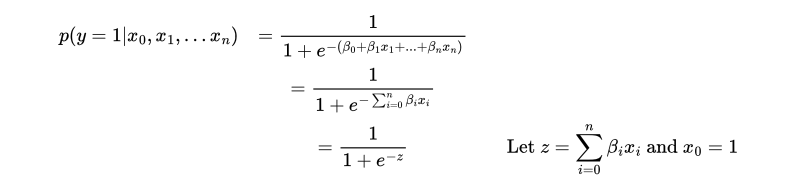

We can show as follows that the linear sum of all the features is equal to the logarithm of the odds of being positive (in our case having chilblains)

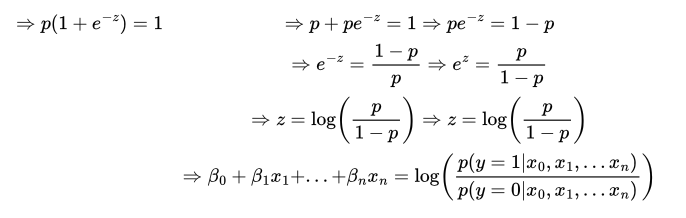

Using this, we can easily show that the each coefficient is equal to the log of the odds ratio of the categorical variable (assuming 0,1 encoding).

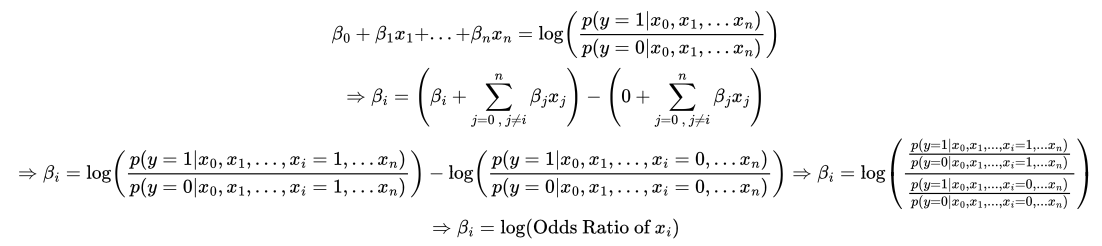

The interpretation for a numerical variable is when 1 x_i = 1 is that we increase the value of the numerical variable by one standard deviation above the mean. For instance if the mean age is 45 and the standard deviation is 5 then we consider the odds(age=50)/odds(age=45)